# Classifieur Decision Tree
L'arbre de décision est un modèle versatile, capable de capturer des structures complexes dans les données. Il offre une interprétabilité relative et peut être utilisé efficacement pour la classification des espèces de feuilles, en identifiant des règles de décision basées sur les caractéristiques extraites.

In [16]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()


(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 195 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Decision Tree, nous utilisons également trois hyperparamètres clés :

- La profondeur maximale de l'arbre (max_depth). Une profondeur à None indique qu'il n'y a pas de restriction sur celle-ci.
- Le nombre minimal d'échantillons requis pour diviser un nœud (min_samples_split).
- Le critère de qualité de la division, qui peut être "gini" ou "entropy".

Bien que la profondeur maximale soit souvent l'hyperparamètre le plus crucial, nous explorons également l'impact des autres hyperparamètres sur les performances du modèle.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

Concernant le choix des valeurs d'hyperparamètres à tester, afin que l'entraînement ne soit pas trop long, nous avons fait des essais préalables pour déterminer les valeurs d'hyperparamètres qui revenaient le plus souvent comme optimales, et nous avons adapté la recherche autour de ces valeurs là. Cela est notamment le cas pour le nombre d'estimateurs, qui était toujours au-dessus de 60.

In [17]:
hyperparameters_dt = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2,3,4,5],
    'criterion': ["gini", "entropy","log_loss"],
    'splitter' : ["best","random"],
}

grid, results = DM.train_model(DecisionTreeClassifier(), hyperparameters_dt, dataset)
print(grid)
print(results)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5, 7],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             verbose=1)
   param_max_depth param_min_samples_split param_criterion param_splitter  \
0             None                       2            gini           best   
1             None                       2            gini         random   
2             None                       3            gini           best   
3             None                       3            gini         random   
4             None                       4            gini           best   
..             ...                     ...             ...            ...   
91               7                       3        log_loss         random   

Suite à l'entraînement, nous pouvons visualiser le premier arbre de décision issu du modèle optimal qui a été trouvé. Cette visualisation textuelle et graphique offre un aperçu détaillé des conditions de décision et des caractéristiques clés utilisées par le modèle pour effectuer des prédictions sur les classes des données.

Tree 1:
|--- shape16 <= 0.00
|   |--- shape63 <= 0.00
|   |   |--- margin2 <= 0.02
|   |   |   |--- texture52 <= 0.01
|   |   |   |   |--- margin45 <= 0.01
|   |   |   |   |   |--- texture27 <= 0.03
|   |   |   |   |   |   |--- margin6 <= 0.01
|   |   |   |   |   |   |   |--- class: 89
|   |   |   |   |   |   |--- margin6 >  0.01
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- texture27 >  0.03
|   |   |   |   |   |   |--- margin53 <= 0.02
|   |   |   |   |   |   |   |--- class: 45
|   |   |   |   |   |   |--- margin53 >  0.02
|   |   |   |   |   |   |   |--- class: 94
|   |   |   |   |--- margin45 >  0.01
|   |   |   |   |   |--- shape35 <= 0.00
|   |   |   |   |   |   |--- margin44 <= 0.01
|   |   |   |   |   |   |   |--- shape38 <= 0.00
|   |   |   |   |   |   |   |   |--- class: 76
|   |   |   |   |   |   |   |--- shape38 >  0.00
|   |   |   |   |   |   |   |   |--- class: 50
|   |   |   |   |   |   |--- margin44 >  0.01
|   |   |   |   |   |   |   |--- shape30 <

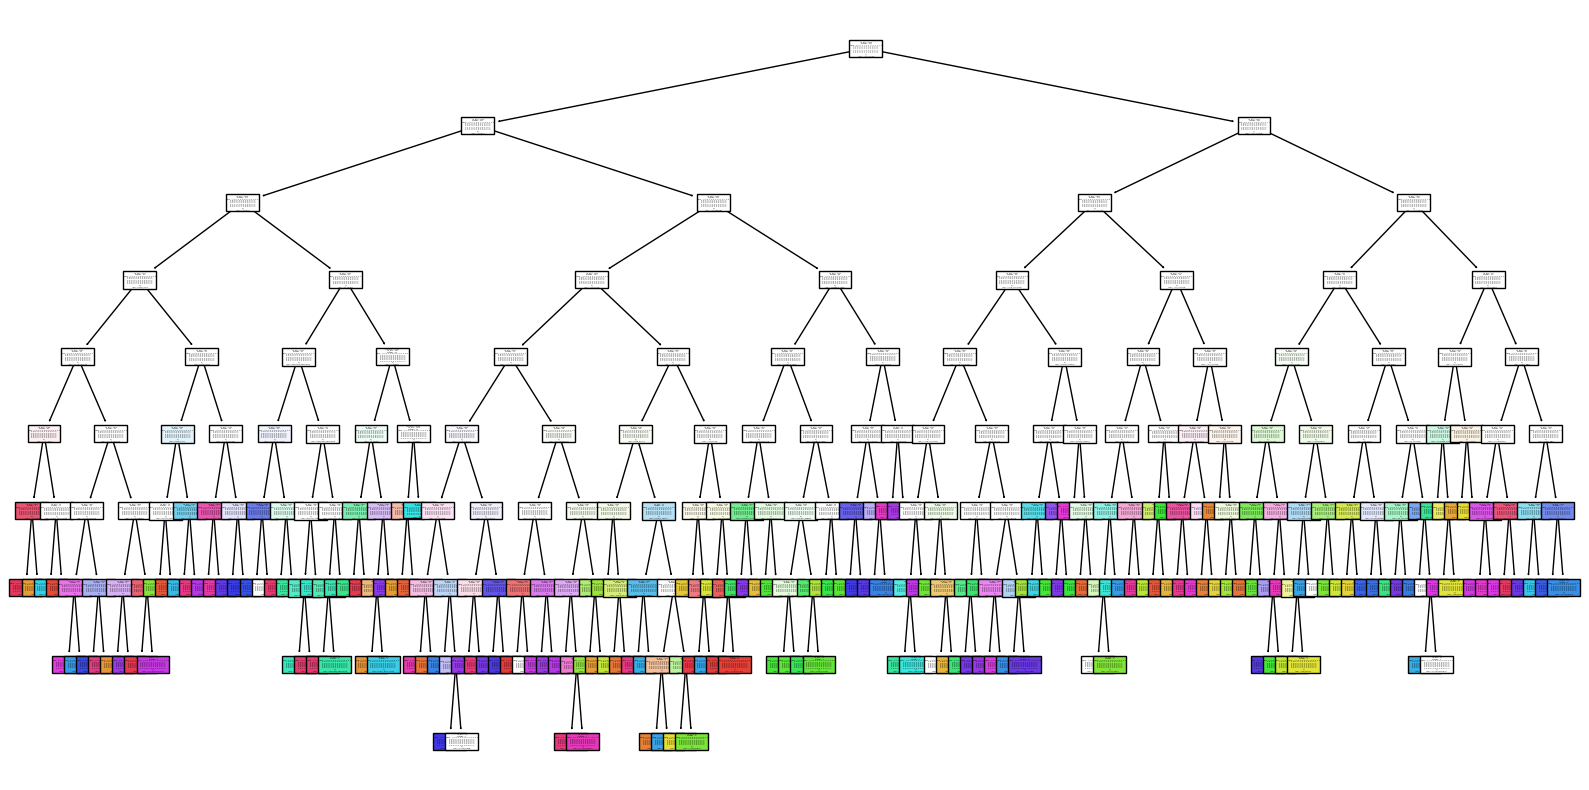

In [11]:
# Importation de la fonction plot_tree
from sklearn.tree import plot_tree, export_text

# Meilleur modèle Decision Tree
best_dt_model = grid.best_estimator_

# Visualiser le premier arbre de la Decision Tree
tree = best_dt_model

# Affichage textuel de l'arbre
tree_text = export_text(tree, feature_names=dataset.data.columns[3:].tolist())
print(f"Tree 1:\n{tree_text}")

# Affichage graphique de l'arbre
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=dataset.data.columns[3:], class_names=dataset.classes)
plt.show()


Dans l'affichage textuel de l'arbre, chaque nœud représente une décision basée sur une caractéristique particulière. Les nœuds feuilles indiquent les prédictions pour chaque classe. En examinant ces conditions de division et les valeurs seuils associées, on peut avoir un aperçu des caractéristiques qui ont été jugées importantes par le modèle pour effectuer des prédictions. Par exemple, on peut observer que la caractéristique shape16 = 0.00 a été déterminante et influence les divisions de l'arbre.

L'affichage graphique, quant à lui, illustre visuellement la structure de l'arbre. Les nœuds internes représentent les conditions de division, les feuilles représentent les résultats de classification, et les branches indiquent le flux de décision. Cette représentation graphique est utile pour visualiser les chemins de décision et comprendre comment le modèle segmente l'espace des caractéristiques pour effectuer des prédictions.



### Analyse de l'entrainement

Le nombre optimal d'estimateurs (n_estimators) est de 80, indiquant ainsi une configuration où le modèle Decision Tree se base sur un ensemble significatif d'arbres de décision pour effectuer des prédictions sur les espèces de feuilles. On peut examiner les performances du modèle en considérant le score associé à ce nombre particulier d'estimateurs et évaluer l'influence des autres hyperparamètres sur ces résultats.

In [34]:
results[results.param_max_depth.isna()].sort_values(by='rank_test_score')

,param_max_depth,param_min_samples_split,param_criterion,param_splitter,mean_test_score,rank_test_score
7,None,5,gini,random,0.595975,1
32,None,2,entropy,best,0.588833,2
3,None,3,gini,random,0.585851,3
5,None,4,gini,random,0.583057,4
68,None,4,log_loss,best,0.581483,5
70,None,5,log_loss,best,0.580065,6
38,None,5,entropy,best,0.571421,7
1,None,2,gini,random,0.571369,8
64,None,2,log_loss,best,0.569930,9
66,None,3,log_loss,best,0.564289,10


Pour la profondeur maximale des arbres, on constate que l'absence de limite de profondeur (None) semble être préférable, car elle obtient le meilleur score (0.595975) pour 24 des 35 meilleures combinaisons d'hyperparamètres. Cela suggère que permettre aux arbres de se développer sans restriction de profondeur donne de meilleurs résultats dans ce contexte.

L'impact de la division minimale des échantillons (min_samples_split) sur les performances n'est pas particulièrement visible. En effet, peu import le nombre de splits minimum, aucune différence notable n'est visible. Cependant, au niveau du criterion et du splitter, on peut voir que le couple (gini,random), est présent dans 3 des 4 meilleurs résultats. 

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

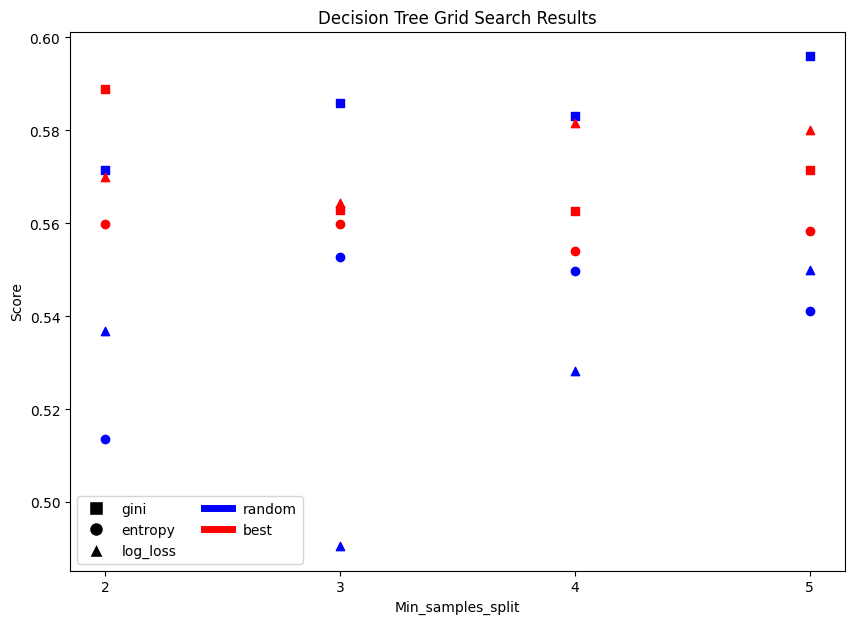

In [50]:
plt.figure(figsize=(10,7))

plt.scatter(results.query('param_criterion == "gini" and param_splitter == "random" and param_max_depth.isna()')['param_min_samples_split'],
            results.query('param_criterion == "gini" and param_splitter == "random" and param_max_depth.isna()')['mean_test_score'],
            marker='s', color='blue')
plt.scatter(results.query('param_criterion == "gini" and param_splitter == "best" and param_max_depth.isna()')['param_min_samples_split'],
            results.query('param_criterion == "gini" and param_splitter == "best" and param_max_depth.isna()')['mean_test_score'],
            marker='o', color='red')
plt.scatter(results.query('param_criterion == "entropy" and param_splitter == "random" and param_max_depth.isna()')['param_min_samples_split'],
            results.query('param_criterion == "entropy" and param_splitter == "random" and param_max_depth.isna()')['mean_test_score'],
            marker='^', color='blue')
plt.scatter(results.query('param_criterion == "entropy" and param_splitter == "best" and param_max_depth.isna()')['param_min_samples_split'],
            results.query('param_criterion == "entropy" and param_splitter == "best" and param_max_depth.isna()')['mean_test_score'],
            marker='s', color='red')
plt.scatter(results.query('param_criterion == "log_loss" and param_splitter == "random" and param_max_depth.isna()')['param_min_samples_split'],
            results.query('param_criterion == "log_loss" and param_splitter == "random" and param_max_depth.isna()')['mean_test_score'],
            marker='o', color='blue')
plt.scatter(results.query('param_criterion == "log_loss" and param_splitter == "best" and param_max_depth.isna()')['param_min_samples_split'],
            results.query('param_criterion == "log_loss" and param_splitter == "best" and param_max_depth.isna()')['mean_test_score'],
            marker='^', color='red')


plt.xlabel("Min_samples_split")
plt.ylabel("Score")
plt.title("Decision Tree Grid Search Results")
plt.xticks(np.arange(2, 6, 1))  # Graduations de 1 en 1 sur l'abscisse
legend = [
    plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='gini'), 
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='entropy'), 
    plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='log_loss'),
    plt.Line2D([0], [0], color='blue', linewidth=5, label='random'),
    plt.Line2D([0], [0], color='red', linewidth=5, label='best')
    ]
plt.legend(handles=legend, ncols=2)

plt.show()
plt.show()


Nous observons que le choix du critère de séparation n'a pas un impact significatif sur les performances du modèle. En effet, les scores moyens obtenus pour les critères "gini", "entropy", et "log_loss" ne présentent pas de différences notables. Cependant, on observe que le critère "gini" tend à obtenir de légèrement meilleures performances en moyenne.

Par ailleurs, en ce qui concerne le choix du séparateur, il semble que le séparateur "best" soit en moyenne plus performant que le séparateur "random". Les résultats montrent que, quel que soit le critère utilisé, le splitter "best" obtient généralement des scores moyens supérieurs. Bien que la différence ne soit pas toujours très significative, cette tendance suggère que le processus de sélection "best" qui évalue toutes les divisions possibles conduit à de meilleures performances que le choix aléatoire de la division "random".

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

C:\Users\Yanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Averages ###
   - precision : 64.701% ± 34.098%
   - recall    : 60.606% ± 33.116%
   - f1_score  : 58.428% ± 28.983%
################


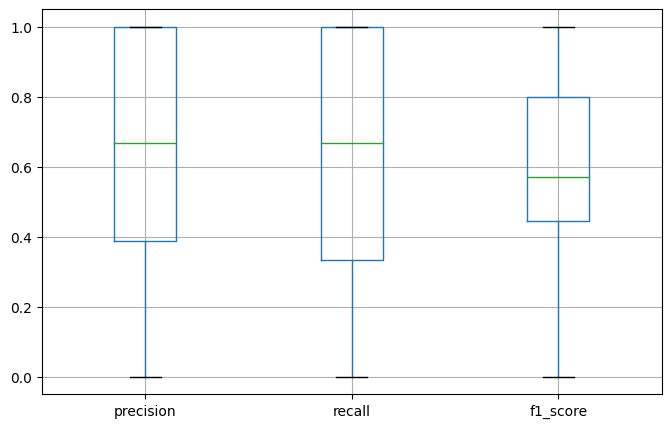

In [51]:
test_preds = grid.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans les boxplots, les prédictions sont loins parfaites pour la grande majorité des classes. En effet, nous avons des boxplots très étendus, avec des médianes ne dépassant pas 0.7,et des quartiles et extrémités de moustaches faibles. 

Nous pouvons ensuite afficher les classes où le modèles a moins bien performé, qui sont au nombre de 85 sur les 99 existantes, témoignant d'un modèle peu performant :

In [52]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                              precision    recall  f1_score
Acer_Circinatum                0.250000  0.333333  0.285714
Acer_Mono                      0.750000  1.000000  0.857143
Acer_Opalus                    0.166667  0.333333  0.222222
Acer_Platanoids                0.750000  1.000000  0.857143
Acer_Rubrum                    1.000000  0.666667  0.800000
...                                 ...       ...       ...
Tilia_Tomentosa                1.000000  0.666667  0.800000
Ulmus_Bergmanniana             1.000000  0.333333  0.500000
Viburnum_Tinus                 0.500000  0.333333  0.400000
Viburnum_x_Rhytidophylloides   0.666667  0.666667  0.666667
Zelkova_Serrata                1.000000  0.333333  0.500000

[85 rows x 3 columns]
Sum: 85


Pour évaluer les performances de notre modèle de Decision Tree, nous pouvons également utiliser une matrice de confusion pour visualiser les prédictions incorrectes sur l'ensemble de test. La matrice de confusion affiche les classifications réelles par rapport aux classifications prédites, permettant ainsi d'identifier les erreurs et les tendances de notre modèle.

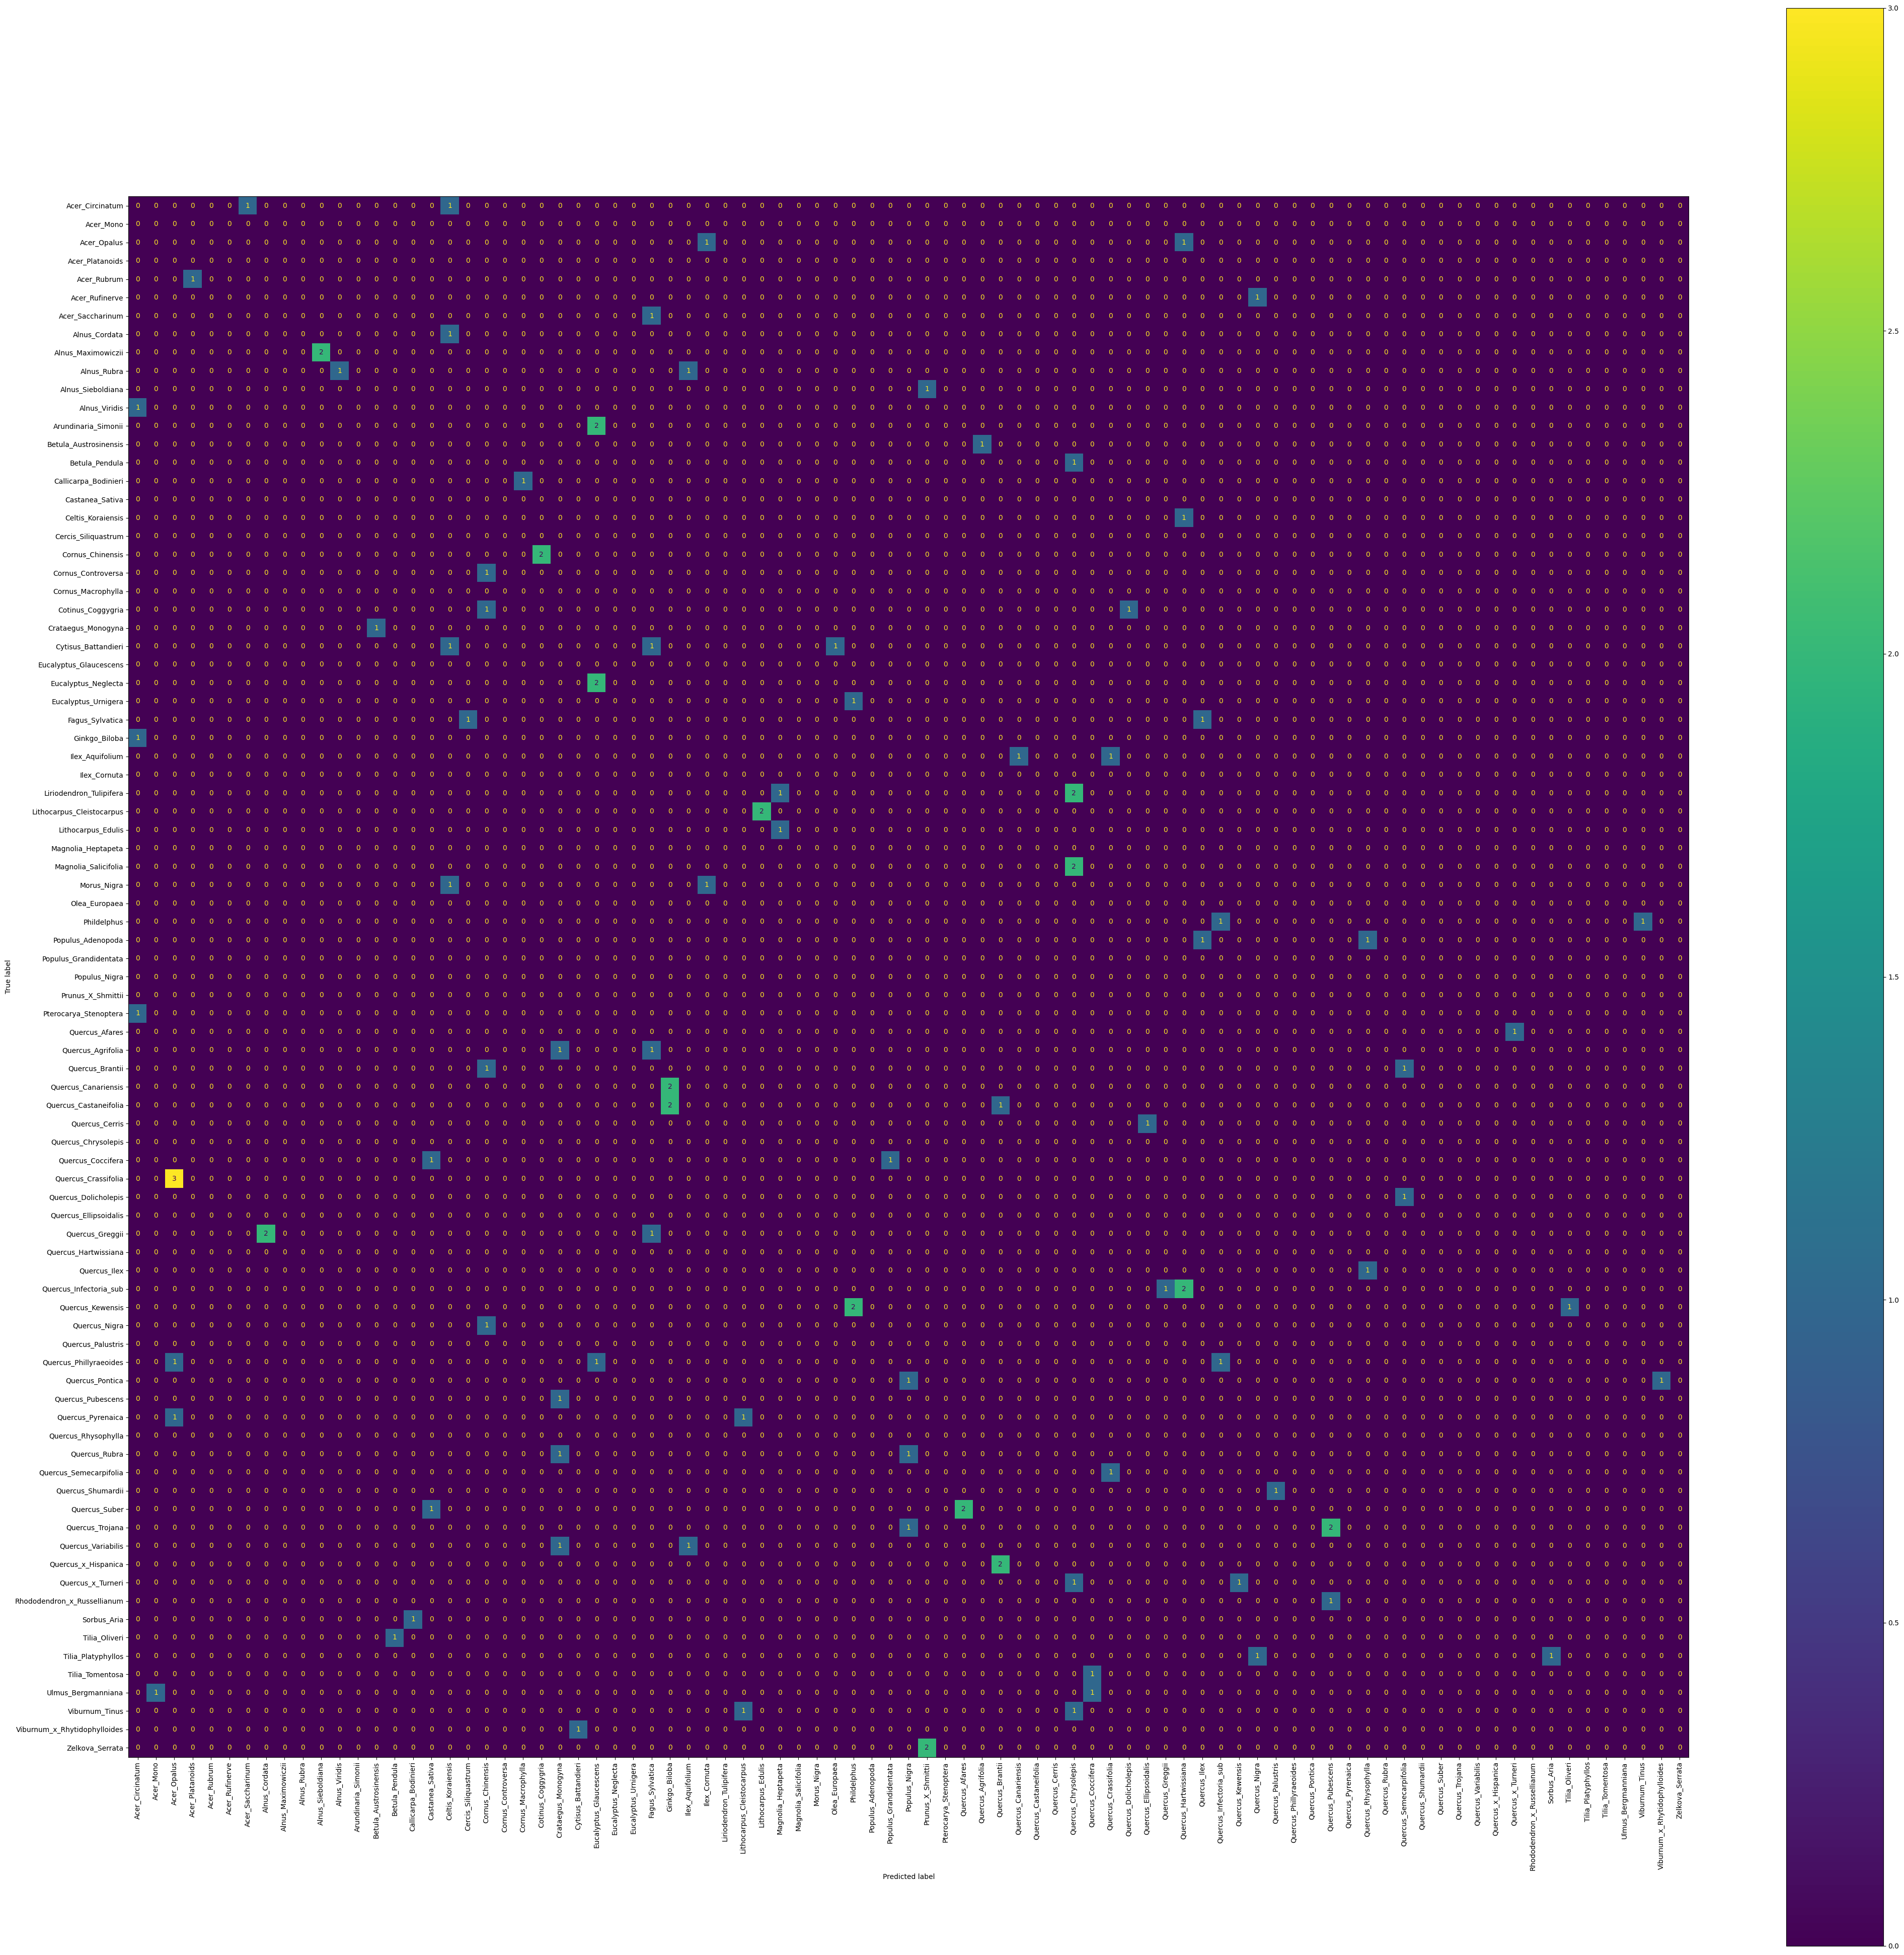

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(50)
display.figure_.set_figheight(50)

plt.show()

Nous observons donc une grande quantité d'erreur pour un grand nombre de classe ayant été prédite à un moment ou à un autre incorrectement. Les grandes dimensions de cette matrice témoigne de ces nombreuses erreurs ayant été commises. 

### Conclusion

Les paramètres optimaux pour notre modèle de Random Forest sont une profondeur maximale illimitée, un nombre minimal d'échantillons pour la division fixé à 5, le critère de séparation "gini", et un séparateur aléatoire. Cependant, malgré ces paramètres ajustés, les performances du modèle restent relativement modestes, les indicateurs de performances ne dépassant pas les 65%.

En effet, les métriques de performance, oscillant entre 58% et 64%, indiquent une capacité de prédiction relativement faible. La nature complexe de notre problème de classification semble dépasser les capacités du classifieur Decision Tree, qui a du mal à saisir les relations subtiles entre les caractéristiques pour discriminer avec précision entre les nombreuses classes.

Il est important de noter que les résultats obtenus ne remettent pas en question l'utilité des arbres de décision dans d'autres contextes, mais plutôt soulignent la nécessité de choisir des modèles adaptés à la complexité de notre ensemble de données spécifique. En conséquence, ces résultats renforcent la pertinence de l'exploration de modèles plus sophistiqués, tels que le classifieur Random Forest, pour traiter efficacement notre problème de classification des espèces de feuilles.
